In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from TrialSolution import TrialSolution

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Example 1

$\frac{d}{dx}\Psi+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$

With boundary initial condition $\Psi(0)=1$ and domain $x\in[0,1]$

In [2]:
X_train = np.arange(0, 1.2, 0.1) + 1e-8
X_train = X_train.reshape(-1,1)
X_test = np.arange(0, 1.2, 0.01) + 1e-8
X_test = X_test.reshape(-1,1) 

In [3]:
inits = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: tf.constant(1., dtype='float64', shape=(X.shape[0],1))}]

The trial solution for this case is $\Psi(x)=1 + x N(x)$.
The first function below is the function $A(x)=1$
and the second function is the function $B(x)=x$.
Though, in our case, the trial solution is generated automatically from the initial conditions.

### Defining the trial solution with an apropiate network

In [4]:
ts = TrialSolution(inits, n_i=1, n_h=10, n_o=1, equation_type='ODE')

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where $N(x)$ is the neural network and $L$ is some differential operator.

In [5]:
def diff_loss(network, inputs):
  # Compute the gradients
  with tf.GradientTape() as tape:
    inputs = tf.convert_to_tensor(inputs)
    tape.watch(inputs)
    response = network(inputs)
  grads = tape.gradient(response, inputs)
  X = inputs
  
  # Compute the loss
  loss = tf.square(grads + tf.multiply(X + (1 + 3*X**2)/(1+X+X**3), response)
          - X**3 -2*X - X**2*(1 + 3*X**2)/(1+X+X**3))
  return loss

### Training

In [6]:
ts.train(X=X_train, diff_loss=diff_loss, epochs=10000, message_frequency=1000, optimizer_name='Adam', learning_rate=0.1)

Epoch: 1000 Loss: 0.044305555522441864
Epoch: 2000 Loss: 0.022394906729459763
Epoch: 3000 Loss: 0.01520667877048254
Epoch: 4000 Loss: 0.01152527891099453
Epoch: 5000 Loss: 0.009409956634044647
Epoch: 6000 Loss: 0.007919552735984325
Epoch: 7000 Loss: 0.006895034108310938
Epoch: 8000 Loss: 0.006112573202699423
Epoch: 9000 Loss: 0.005469979252666235
Epoch: 10000 Loss: 0.004977641627192497


### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

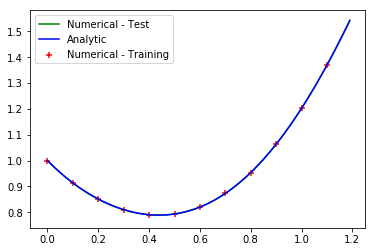

In [7]:
pred_train = ts.call(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
pred_test = ts(tf.convert_to_tensor(X_test, dtype='float64')).numpy()
plt.scatter(X_train, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
plt.plot(X_test, pred_test, c='g', label='Numerical - Test')
plt.plot(X_test, np.exp(-0.5*X_test**2)/(1+X_test+X_test**3) + X_test**2, c='b', label='Analytic')
plt.legend()
plt.show()

Let's check the errors on the training set.

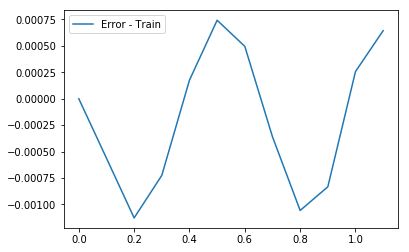

In [8]:
plt.plot(X_train, pred_train - np.exp(-0.5*X_train**2)/(1+X_train+X_train**3) - X_train**2, label='Error - Train')
plt.legend()
plt.show()

Let's check the errors on the test set.

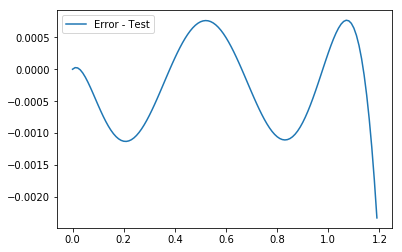

In [9]:
plt.plot(X_test, pred_test - np.exp(-0.5*X_test**2)/(1+X_test+X_test**3) - X_test**2, label='Error - Test')
plt.legend()
plt.show()

The mean loss calculated on the test set.

In [10]:
diff_loss(ts, X_test).numpy().mean()

0.0001794044550656551

Mean absolute error on the train set.

In [11]:
np.abs(pred_train - np.exp(-0.5*X_train**2)/(1+X_train+X_train**3) - X_train**2).mean()

0.0005818346956702301

Mean absolute error on the test set - interpolation error.

In [12]:
np.abs(pred_test - np.exp(-0.5*X_test**2)/(1+X_test+X_test**3) - X_test**2).mean()

0.0006204851923145942